### Q3. What groups are best optimizing their memory usage in terms of percent of actual memory used of the memory requested for a job? What is the average percent for each group?
* Name the dataframe ``accre_mem_use``
* Filter out rows with ``EXITCODE`` values that are not '0:0' (success)
* for a)
    * Sum 6-month totals for each user group
    * Get an average for the group by summing their total requested and total utilized memory
    * Visualize this across the groups (which ones are doing well, which ones are not doing as well)

* for b)
    * Group the dataframe by the user groups
    * Create a new column denoting each job's percent utilization
    * Get a median % for the group
    * Visualize the range and std deviation and/or IQR and median for the top and bottom performers


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
accre_mem_use = pd.read_csv('../data/accre_cleaned_no_nodelist.csv')
accre_mem_use.head()

,Unnamed: 0,JOBID,ACCOUNT,USER,REQMEM,REQMEM_PER_CORE,USEDMEM,USEDMEM_PER_CORE,REQTIME,REQTIME_SEC,USEDTIME,USEDTIME_SEC,NODES,CPUS,PARTITION,EXITCODE,STATE
0,0,15925210,treviso,arabella,122880Mn,5120.0,65973.49M,2748.875000,13-18:00:00,1188000.0,13-18:00:28,1188028.0,1,24,production,0:0,COMPLETED
1,1,15861126,treviso,arabella,122880Mn,5120.0,67181.12M,2799.208333,13-18:00:00,1188000.0,12-14:50:56,1090256.0,1,24,production,0:0,COMPLETED
2,2,15861125,treviso,arabella,122880Mn,5120.0,69111.86M,2879.625000,13-18:00:00,1188000.0,13-18:00:20,1188020.0,1,24,production,0:0,COMPLETED
3,3,16251645,treviso,arabella,122880Mn,5120.0,65317.33M,2721.541667,13-18:00:00,1188000.0,12-03:50:32,1050632.0,1,24,production,0:0,COMPLETED
4,4,16251646,treviso,arabella,122880Mn,5120.0,65876.11M,2744.833333,13-18:00:00,1188000.0,13-18:00:03,1188003.0,1,24,production,0:0,COMPLETED


In [4]:
accre_mem_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3816290 entries, 0 to 3816289
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   JOBID             object 
 2   ACCOUNT           object 
 3   USER              object 
 4   REQMEM            object 
 5   REQMEM_PER_CORE   float64
 6   USEDMEM           object 
 7   USEDMEM_PER_CORE  float64
 8   REQTIME           object 
 9   REQTIME_SEC       float64
 10  USEDTIME          object 
 11  USEDTIME_SEC      float64
 12  NODES             int64  
 13  CPUS              int64  
 14  PARTITION         object 
 15  EXITCODE          object 
 16  STATE             object 
dtypes: float64(4), int64(3), object(10)
memory usage: 495.0+ MB


In [6]:
# To filter out all CMS accounts, start with this list:
cms = ['cms', 'cms_gpu_acc', 'cms_lowprio', 'cmsadmin']
# Then create a CMS-free dataframe:
accre_mem_no_cms = accre_mem_use[~accre_mem_use['ACCOUNT'].isin(cms)]
# Check to make sure CMS is removed from the Accounts in the new dataframe:
accre_mem_no_cms.ACCOUNT.sort_values().unique()

array(['alkmene', 'almonds', 'amaranth', 'angelys', 'anise', 'antares',
       'arra', 'atemoyas', 'baby', 'baking', 'basil', 'bay', 'bell',
       'belle', 'bertanne', 'bibb', 'blackberries', 'blueberries', 'bon',
       'boysenberries', 'brazilnuts', 'broccoli', 'bulk', 'bunch',
       'burro', 'cactus', 'cantared', 'carambola', 'carrot', 'casaba',
       'celery', 'cep', 'cepuna', 'champagne', 'chanterelle', 'chasselas',
       'chayote', 'chickpeas', 'chipilin', 'cinnabar', 'clara',
       'cocktail', 'concord', 'conference', 'crab', 'crowns', 'cubanelle',
       'delblush', 'dill', 'discovery', 'emmons', 'endive', 'enoki',
       'fairchild', 'fava', 'fiddlehead', 'flamingo', 'florence',
       'forelle', 'francis', 'fresh', 'galangal', 'galia', 'garlic',
       'gem', 'glasshouse', 'gobo', 'golden', 'grisette', 'harovin',
       'hass', 'hearts', 'horn', 'horseradish', 'huaguan', 'ingrid',
       'jicama', 'josephine', 'kabocha', 'key', 'kinnow', 'kumquat',
       'large', 'laxto

In [7]:
accre_mem_use['EXITCODE'].value_counts()

0:0      3813403
1:0         1155
0:9          838
0:15         354
127:0        143
2:0          135
0:125         95
7:0           48
0:7           15
6:0           15
13:0          11
0:11          11
126:0         11
38:0           9
24:0           7
11:0           6
0:39           5
59:0           4
0:6            4
116:0          4
0:12           3
99:0           2
0:2            2
0:105          2
64:0           2
8:0            2
101:0          1
16:0           1
0:36           1
0:4            1
Name: EXITCODE, dtype: int64

In [8]:
# Only get successful jobs
accre_mem_use = accre_mem_use[accre_mem_use['EXITCODE'] == '0:0']
accre_mem_use.head()

,Unnamed: 0,JOBID,ACCOUNT,USER,REQMEM,REQMEM_PER_CORE,USEDMEM,USEDMEM_PER_CORE,REQTIME,REQTIME_SEC,USEDTIME,USEDTIME_SEC,NODES,CPUS,PARTITION,EXITCODE,STATE
0,0,15925210,treviso,arabella,122880Mn,5120.0,65973.49M,2748.875000,13-18:00:00,1188000.0,13-18:00:28,1188028.0,1,24,production,0:0,COMPLETED
1,1,15861126,treviso,arabella,122880Mn,5120.0,67181.12M,2799.208333,13-18:00:00,1188000.0,12-14:50:56,1090256.0,1,24,production,0:0,COMPLETED
2,2,15861125,treviso,arabella,122880Mn,5120.0,69111.86M,2879.625000,13-18:00:00,1188000.0,13-18:00:20,1188020.0,1,24,production,0:0,COMPLETED
3,3,16251645,treviso,arabella,122880Mn,5120.0,65317.33M,2721.541667,13-18:00:00,1188000.0,12-03:50:32,1050632.0,1,24,production,0:0,COMPLETED
4,4,16251646,treviso,arabella,122880Mn,5120.0,65876.11M,2744.833333,13-18:00:00,1188000.0,13-18:00:03,1188003.0,1,24,production,0:0,COMPLETED


In [9]:
accre_mem_use['PARTITION'].sort_values().unique()

array(['cgw-capra1', 'cgw-cqs1', 'cgw-cqs3', 'cgw-dougherty1',
       'cgw-rocksteady', 'cgw-tbi01', 'cgw-vm-qa-flatearth1', 'debug',
       'devel', 'maxwell', 'nogpfs', 'pascal', 'production', 'sam',
       'turing'], dtype=object)

In [10]:
# To filter out partitions that are not of general interest:
par = ['debug', 'maxwell', 'nogpfs', 'pascal', 'turing']
accre_mem_use = accre_mem_use[~accre_mem_use['PARTITION'].isin(par)]

In [11]:
accre_mem_use['USEDMEM_TOT'] = accre_mem_use['USEDMEM_PER_CORE']*accre_mem_use['CPUS']
accre_mem_use['REQMEM_TOT'] = accre_mem_use['REQMEM_PER_CORE']*accre_mem_use['CPUS']

In [12]:
# accre_grouped_by_user = accre_mem_use.groupby(['ACCOUNT', 'USER']).agg(
#     {  'USEDMEM_TOT': 'sum',
#        'REQMEM_TOT': 'sum',
#        'JOBID': 'count'
#    }
#)
#accre_grouped_by_user.head(200)

In [13]:
accre_grouped_by_account = accre_mem_use.groupby('ACCOUNT').agg(
    {  'USEDMEM_TOT': 'sum',
        'REQMEM_TOT': 'sum',
        'JOBID': 'count'
    }
)
accre_grouped_by_account.head(200)

,USEDMEM_TOT,REQMEM_TOT,JOBID
ACCOUNT,,,
alkmene,4.654253e+07,1.369927e+08,15598
almonds,2.567816e+06,1.927117e+07,1887
amaranth,7.313580e+05,2.484634e+07,3033
angelys,2.495000e+03,9.635840e+05,903
anise,1.045693e+07,5.127960e+07,1754
antares,2.425510e+05,4.915200e+05,160
arra,1.366660e+06,1.072947e+07,65
atemoyas,1.713274e+07,2.669599e+08,25019
baby,3.776754e+06,3.186000e+08,3186


In [14]:
# Create a new column, USEDMEM_PCT, which contains the % of memory utilization grouped by each account:
accre_grouped_by_account['USEDMEM_PCT'] = (accre_grouped_by_account['USEDMEM_TOT'] / accre_grouped_by_account['REQMEM_TOT'])*100

In [15]:
accre_grouped_by_account.reset_index(inplace=True)

In [16]:
accre_grouped_by_account.columns

Index(['ACCOUNT', 'USEDMEM_TOT', 'REQMEM_TOT', 'JOBID', 'USEDMEM_PCT'], dtype='object')

In [17]:
accre_grouped_by_account.head(200)

,ACCOUNT,USEDMEM_TOT,REQMEM_TOT,JOBID,USEDMEM_PCT
0,alkmene,4.654253e+07,1.369927e+08,15598,33.974456
1,almonds,2.567816e+06,1.927117e+07,1887,13.324652
2,amaranth,7.313580e+05,2.484634e+07,3033,2.943525
3,angelys,2.495000e+03,9.635840e+05,903,0.258929
4,anise,1.045693e+07,5.127960e+07,1754,20.391996
5,antares,2.425510e+05,4.915200e+05,160,49.347127
6,arra,1.366660e+06,1.072947e+07,65,12.737439
7,atemoyas,1.713274e+07,2.669599e+08,25019,6.417720
8,baby,3.776754e+06,3.186000e+08,3186,1.185422
9,baking,1.553527e+07,5.794816e+07,494,26.808917


In [18]:
accre_grouped_by_account_sorted = accre_grouped_by_account.sort_values(by=['USEDMEM_PCT', 'JOBID'], ascending = [True,False])

In [19]:
accre_grouped_by_account_sorted.head()

,ACCOUNT,USEDMEM_TOT,REQMEM_TOT,JOBID,USEDMEM_PCT
52,florence,0.0,40960.0,2,0.0
60,golden,0.0,8192.0,2,0.0
109,president,0.0,6144.0,2,0.0
138,wa,0.0,4096.0,2,0.0
46,discovery,0.0,2048.0,1,0.0


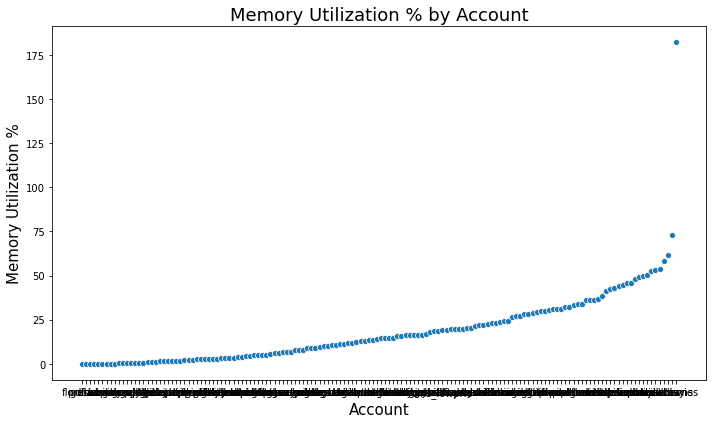

In [20]:
plt.figure(figsize=(10,6))
# make barplot
sns.scatterplot(x='ACCOUNT', y='USEDMEM_PCT', data=accre_grouped_by_account_sorted)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization % by Account', size=18)
plt.tight_layout()
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


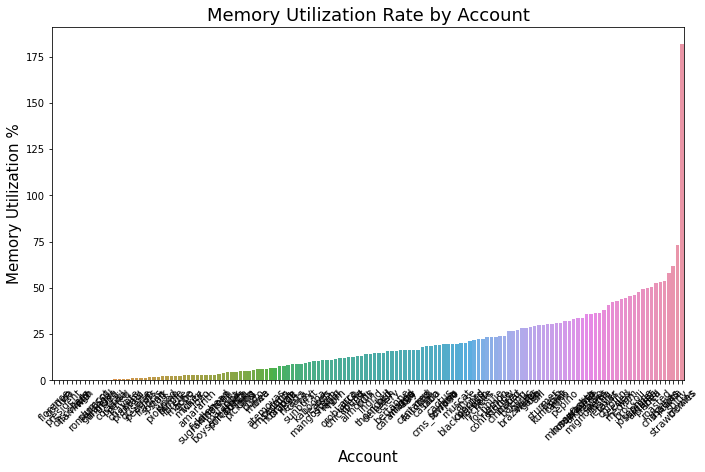

In [21]:
plt.figure(figsize=(10,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT', data=accre_grouped_by_account_sorted)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization Rate by Account', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


In [22]:
accre_grouped_by_account_sorted['USEDMEM_QNTL'] = pd.qcut(accre_grouped_by_account_sorted['USEDMEM_PCT'], q=5)

In [23]:
accre_grouped_by_account_sorted['USEDMEM_QNTL'].value_counts()

(-0.001, 2.589]      30
(31.223, 181.978]    29
(18.713, 31.223]     29
(9.326, 18.713]      29
(2.589, 9.326]       29
Name: USEDMEM_QNTL, dtype: int64

In [24]:
bin_labels_5 = ['QNT1', 'QNT2', 'QNT3', 'QNT4', 'QNT5']
accre_grouped_by_account_sorted['USEDMEM_QNTL'] = pd.qcut(accre_grouped_by_account_sorted['USEDMEM_PCT'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels_5)
accre_grouped_by_account_sorted.head()

,ACCOUNT,USEDMEM_TOT,REQMEM_TOT,JOBID,USEDMEM_PCT,USEDMEM_QNTL
52,florence,0.0,40960.0,2,0.0,QNT1
60,golden,0.0,8192.0,2,0.0,QNT1
109,president,0.0,6144.0,2,0.0,QNT1
138,wa,0.0,4096.0,2,0.0,QNT1
46,discovery,0.0,2048.0,1,0.0,QNT1


In [25]:
accre_grouped_by_account_sorted.head()

,ACCOUNT,USEDMEM_TOT,REQMEM_TOT,JOBID,USEDMEM_PCT,USEDMEM_QNTL
52,florence,0.0,40960.0,2,0.0,QNT1
60,golden,0.0,8192.0,2,0.0,QNT1
109,president,0.0,6144.0,2,0.0,QNT1
138,wa,0.0,4096.0,2,0.0,QNT1
46,discovery,0.0,2048.0,1,0.0,QNT1


In [26]:
accre_top_20_pct_groups = accre_grouped_by_account_sorted[accre_grouped_by_account_sorted['USEDMEM_QNTL'] == 'QNT5' ]

In [27]:
accre_bottom_20_pct_groups = accre_grouped_by_account_sorted[accre_grouped_by_account_sorted['USEDMEM_QNTL'] == 'QNT1']

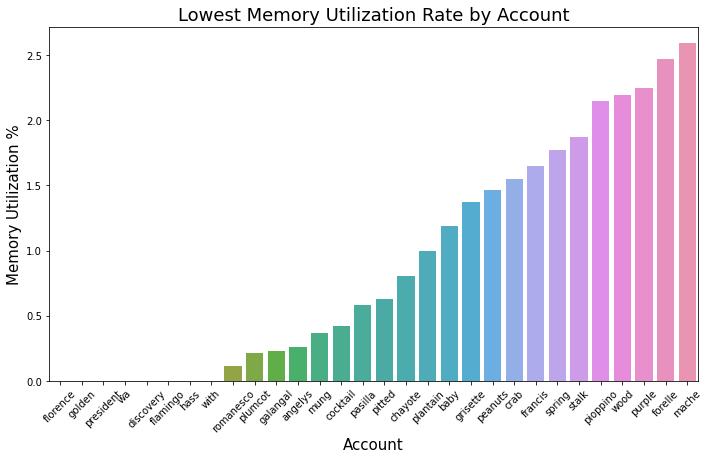

In [39]:
plt.figure(figsize=(10,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT', data=accre_bottom_20_pct_groups)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Lowest Memory Utilization Rate by Account', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

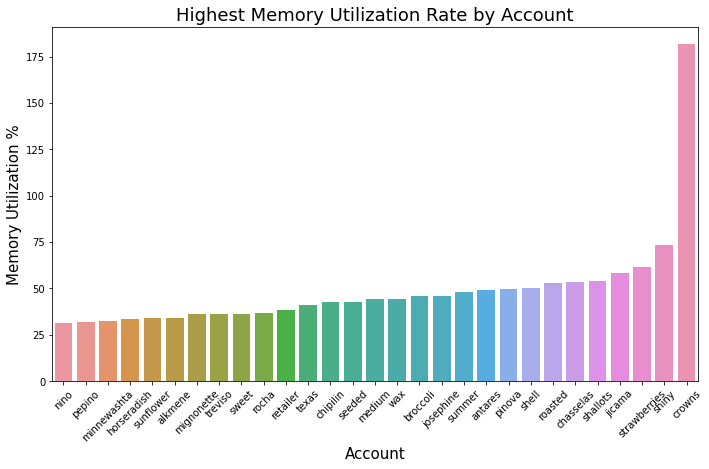

In [29]:
plt.figure(figsize=(10,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT', data=accre_top_20_pct_groups)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Highest Memory Utilization Rate by Account', size=18)
plt.tight_layout()
plt.xticks(rotation=45)
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


In [38]:
# Check to see what's going on with the crowns account:
accre_mem_use[accre_mem_use['ACCOUNT'] == 'crowns']
# It looks like they're

,Unnamed: 0,JOBID,ACCOUNT,USER,REQMEM,REQMEM_PER_CORE,USEDMEM,USEDMEM_PER_CORE,REQTIME,REQTIME_SEC,USEDTIME,USEDTIME_SEC,NODES,CPUS,PARTITION,EXITCODE,STATE,USEDMEM_TOT,REQMEM_TOT,JOB_USEDMEM_PCT
163772,163772,17324222,crowns,tena,5120Mc,5120.0,9651.66M,9651.0,2-00:00:00,172800.0,16:47:47,60467.0,37,1,production,0:0,COMPLETED,9651.0,5120.0,NaN
201540,201540,17356683,crowns,tena,5120Mc,5120.0,5036.63M,5036.0,1-06:00:00,108000.0,13:21:03,48063.0,126,1,production,0:0,COMPLETED,5036.0,5120.0,NaN
233631,233631,17407978,crowns,tena,5120Mc,5120.0,0,0.0,1-06:00:00,108000.0,00:00:13,13.0,40,1,production,0:0,COMPLETED,0.0,5120.0,NaN
283156,283156,17459047,crowns,tena,5120Mc,5120.0,4852.45M,4852.0,2-00:00:00,172800.0,09:20:56,33656.0,75,1,production,0:0,COMPLETED,4852.0,5120.0,NaN
289774,289774,17487107,crowns,tena,5120Mc,5120.0,3969.25M,3969.0,1-00:00:00,86400.0,05:43:07,20587.0,97,1,production,0:0,COMPLETED,3969.0,5120.0,NaN
1029693,1029693,18680401,crowns,tena,5120Mc,5120.0,7076.92M,7076.0,1-06:00:00,108000.0,11:21:07,40867.0,112,1,production,0:0,COMPLETED,7076.0,5120.0,NaN
1647787,1647787,19804780,crowns,tena,5120Mc,5120.0,904.34M,904.0,08:00:00,28800.0,00:21:44,1304.0,50,1,production,0:0,COMPLETED,904.0,5120.0,NaN
1849154,1849154,20231233,crowns,tena,5120Mc,5120.0,832.43M,832.0,1-00:00:00,86400.0,00:22:25,1345.0,109,1,production,0:0,COMPLETED,832.0,5120.0,NaN
2615269,2615269,21963752,crowns,tena,5120Mc,5120.0,2669.98M,2669.0,3-00:00:00,259200.0,2-15:26:44,228404.0,142,1,production,0:0,COMPLETED,2669.0,5120.0,NaN
2685752,2685752,22106231,crowns,wilhelmina,5120Mc,5120.0,29040.23M,29040.0,1-00:00:00,86400.0,00:01:42,102.0,44,1,production,0:0,COMPLETED,29040.0,5120.0,NaN


In [30]:
accre_grouped_by_account_sorted['USEDMEM_PCT'].agg(['max', 'min'])

max    181.978237
min      0.000000
Name: USEDMEM_PCT, dtype: float64

In [31]:
accre_grouped_by_sorted_by_USEDMEM = accre_grouped_by_account.sort_values(by=['USEDMEM_TOT', 'USEDMEM_PCT'], ascending = [False,True])

In [32]:
accre_grouped_by_sorted_by_USEDMEM.head()

,ACCOUNT,USEDMEM_TOT,REQMEM_TOT,JOBID,USEDMEM_PCT
129,summer,2.998449e+09,6.238030e+09,380684,48.067235
36,cms,1.699637e+09,9.452231e+09,491085,17.981337
29,cep,8.364970e+08,2.856553e+09,609130,29.283435
57,galia,6.871519e+08,2.380824e+09,198176,28.861940
26,carrot,4.513056e+08,1.445444e+09,192498,31.222624


In [33]:
bin_labels_5 = ['QNT1', 'QNT2', 'QNT3', 'QNT4', 'QNT5']
accre_grouped_by_sorted_by_USEDMEM['USEDMEM_QNTL'] = pd.qcut(accre_grouped_by_sorted_by_USEDMEM['USEDMEM_TOT'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels_5)
accre_grouped_by_sorted_by_USEDMEM.head()

,ACCOUNT,USEDMEM_TOT,REQMEM_TOT,JOBID,USEDMEM_PCT,USEDMEM_QNTL
129,summer,2.998449e+09,6.238030e+09,380684,48.067235,QNT5
36,cms,1.699637e+09,9.452231e+09,491085,17.981337,QNT5
29,cep,8.364970e+08,2.856553e+09,609130,29.283435,QNT5
57,galia,6.871519e+08,2.380824e+09,198176,28.861940,QNT5
26,carrot,4.513056e+08,1.445444e+09,192498,31.222624,QNT5


In [34]:
accre_grouped_by_account_sorted['USEDMEM_QNTL'].value_counts()

QNT1    30
QNT5    29
QNT4    29
QNT3    29
QNT2    29
Name: USEDMEM_QNTL, dtype: int64

In [48]:
accre_top_20_pct_group_by_usedmem = accre_grouped_by_sorted_by_USEDMEM[accre_grouped_by_sorted_by_USEDMEM['USEDMEM_QNTL'] == 'QNT5' ]

In [49]:
accre_bottom_20_pct_group_by_usedmem = accre_grouped_by_sorted_by_USEDMEM[accre_grouped_by_sorted_by_USEDMEM['USEDMEM_QNTL'] == 'QNT1' ]

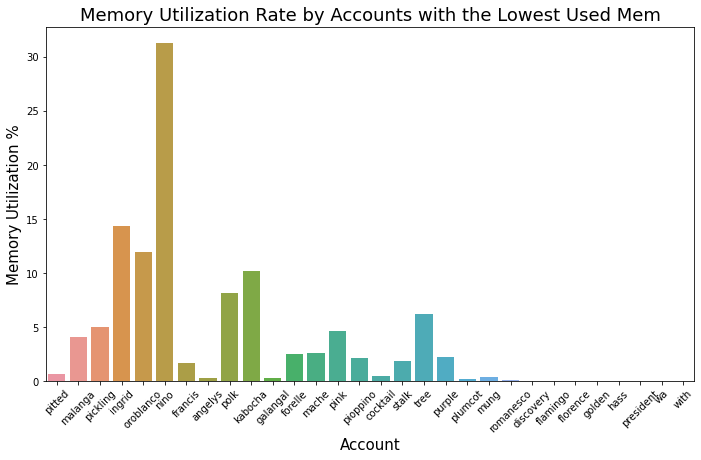

In [50]:
plt.figure(figsize=(10,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT', data=accre_bottom_20_pct_group_by_usedmem)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization Rate by Accounts with the Lowest Used Mem', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


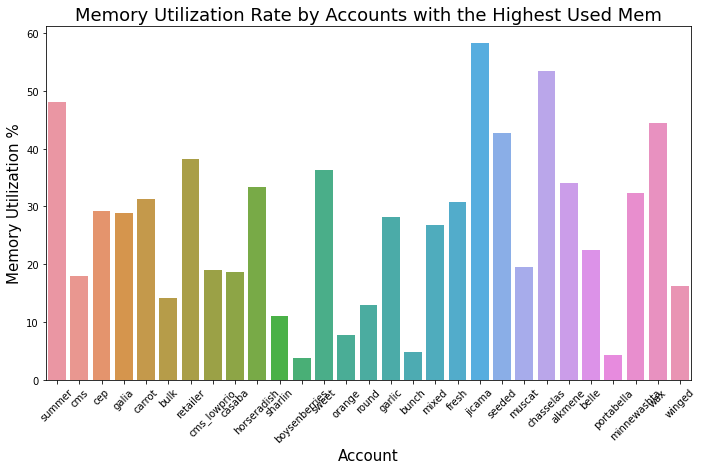

In [51]:
plt.figure(figsize=(10,6))
# make barplot
sns.barplot(x='ACCOUNT', y='USEDMEM_PCT', data=accre_top_20_pct_group_by_usedmem)
# set labels
plt.xlabel('Account', size=15)
plt.ylabel('Memory Utilization %', size=15)
plt.title('Memory Utilization Rate by Accounts with the Highest Used Mem', size=18)
plt.tight_layout()
plt.xticks(rotation=45);
# plt.savefig("barplot_Seaborn_Python.png", dpi=100)


In [35]:
accre_grouped_by_account_sorted['ACCOUNT'].nunique()

146

In [36]:
accre_mem_use['JOB_USEDMEM_PCT'] = (accre_grouped_by_account['USEDMEM_TOT'] / accre_grouped_by_account['REQMEM_TOT'])*100